# **1.** Load a data batch

In [1]:
from dataset import RadSamDataset

train_dataset = RadSamDataset(
    "/Users/eustachelebihan/Development/radium-challenge/data/x-train",
    "/Users/eustachelebihan/Development/radium-challenge/sam/data/masks_200_400.pkl",
    "/Users/eustachelebihan/Development/radium-challenge/sam/data/pnts_200_400.pkl",
    200,
    400,
)

0


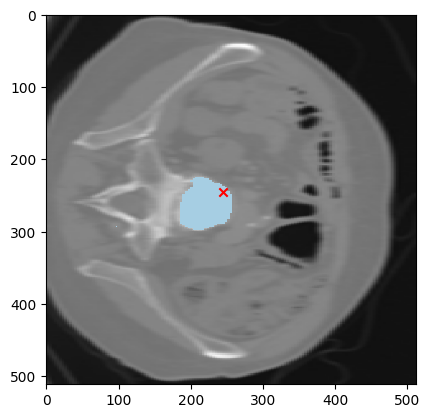

In [2]:
train_dataset.verif(2)

In [3]:
from torch.utils.data import DataLoader

dataloader = DataLoader(
    train_dataset,
    batch_size=3
)

In [8]:
input_image, (coords_torch, labels_torch), masks, (img_n_t, orig_coords_t) = train_dataset[15]

In [9]:
for input_image, (coords_torch, labels_torch), masks, (img_n_t, orig_coords_t) in dataloader:
    break

In [10]:
print(masks.shape)

torch.Size([3, 512, 512])


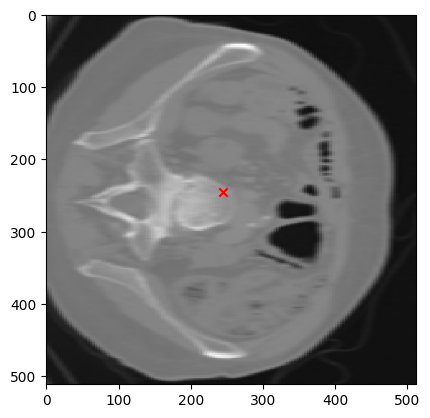

In [7]:
import cv2
import matplotlib.pyplot as plt 

def plot_from_batch(img_ns, orig_coords, i):

    img_n = img_ns[i].item()
    y, x = orig_coords[i].squeeze()
    img_path = f"/Users/eustachelebihan/Development/radium-challenge/data/x-train/{img_n}.png"
    img = cv2.imread(img_path)

    # plot
    plt.imshow(img)
    plt.scatter(x, y, marker='x', c='red')
    plt.axis("on")


plot_from_batch(img_n_t, orig_coords_t, 2)

# **2.** Load model

In [12]:
# build model from checkpoint

# import sys
# sys.path.append("/Users/eustachelebihan/Development/segment-anything")


from segment_anything import sam_model_registry

sam_checkpoint = "/Users/eustachelebihan/Downloads/sam_vit_b_01ec64.pth"
model_type = "vit_b"
model = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# **3.** Infer model on batch

In [13]:
import torch

# encode image
with torch.no_grad():
    features = model.image_encoder(img_batch)

In [14]:
# encode prompts

with torch.no_grad():
    sparse_embeddings, dense_embeddings = model.prompt_encoder(
        points=points,
        boxes=None,
        masks=None,
    )

In [15]:
print(features.shape)
print(sparse_embeddings.shape)
print(dense_embeddings.shape)

torch.Size([3, 256, 64, 64])
torch.Size([3, 2, 256])
torch.Size([3, 256, 64, 64])


In [16]:
print(model.prompt_encoder.get_dense_pe().shape)

torch.Size([1, 256, 64, 64])


In [17]:
# Predict masks

with torch.no_grad():
    # low_res_masks, iou_predictions = model.mask_decoder(
    #     image_embeddings=features,
    #     image_pe=model.prompt_encoder.get_dense_pe(),
    #     sparse_prompt_embeddings=sparse_embeddings,
    #     dense_prompt_embeddings=dense_embeddings,
    #     multimask_output=True,
    # )

    b, *_ = img_batch.shape

    batched_masks = []
    batched_iou_preductions = []

    for i in range(b):

        low_res_masks, iou_predictions = model.mask_decoder(
            image_embeddings=features[i].unsqueeze(0),
            image_pe=model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings[i].unsqueeze(0),
            dense_prompt_embeddings=dense_embeddings[i].unsqueeze(0),
            multimask_output=True,
        )
        
        masks = model.postprocess_masks(low_res_masks, (1024, 1024), (512, 512))
        batched_masks.append(masks)
        batched_iou_preductions.append(iou_predictions)

    batched_masks = torch.cat(batched_masks, dim=0)
    batched_iou_preductions = torch.cat(batched_iou_preductions, dim=0)

# Upscale the masks to the original image resolution
# masks = model.postprocess_masks(low_res_masks, (1024, 1024), (512, 512))
# print(masks.shape)
    
masks = batched_masks
iou_predictions = batched_iou_preductions

print(masks.shape)
print(iou_predictions.shape)

i = 2
masks_np = masks[i].detach().cpu().numpy()
iou_predictions_np = iou_predictions[i].detach().cpu().numpy()
# low_res_masks_np = low_res_masks[i].detach().cpu().numpy()

torch.Size([3, 3, 512, 512])
torch.Size([3, 3])


# **4.** Interpret results

In [18]:
import numpy as np
import matplotlib.pyplot as plt


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

In [19]:
masks = masks_np
scores = iou_predictions_np

masks = masks > model.mask_threshold

In [20]:
print(scores)
print(masks.shape)

[0.9782591  0.77984613 0.6478598 ]
(3, 512, 512)


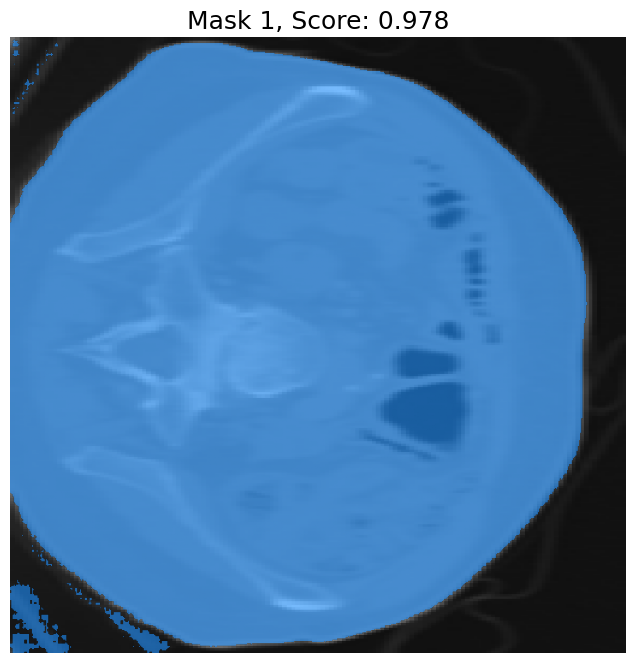

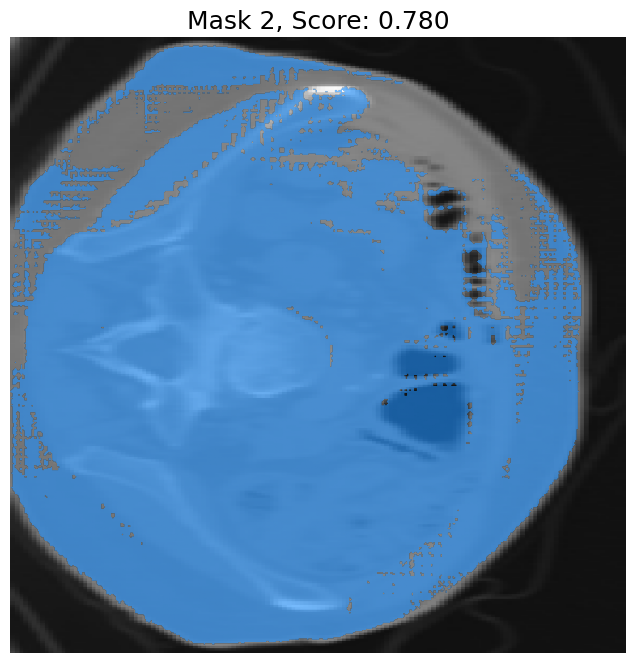

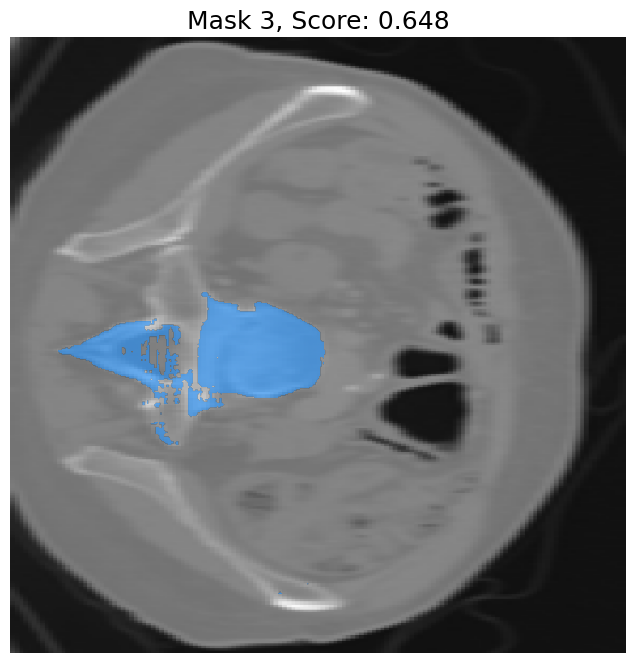

In [21]:
import cv2

image = cv2.imread('/Users/eustachelebihan/Development/radium-challenge/data/x-train/200.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    
    # show_points(points[0].squeeze().numpy(), points[0].squeeze().numpy(), plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

# **5.** Let's now use our model

In [22]:
from model import RadSam

radsam_model = RadSam(
    model.image_encoder,
    model.mask_decoder,
    model.prompt_encoder
)

In [28]:
with torch.no_grad():
    masks, scores = radsam_model(
        img_batch,
        points
    )

torch.Size([256, 64, 64])
torch.Size([256, 64, 64])
torch.Size([256, 64, 64])


In [31]:
masks = masks[i].detach().cpu().numpy()
scores = scores[i].detach().cpu().numpy()

masks = masks > model.mask_threshold

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [32]:
print(masks.shape)

(3, 512, 512)


In [33]:
print(scores)

[0.9782591  0.77984613 0.6478598 ]


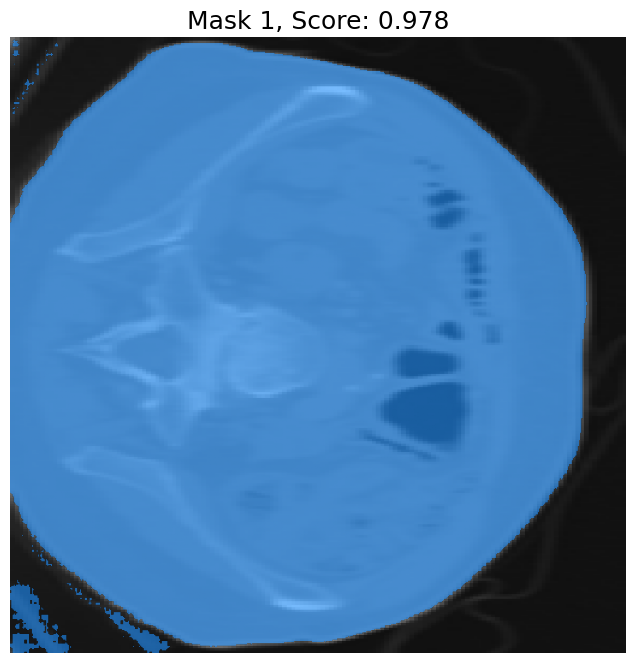

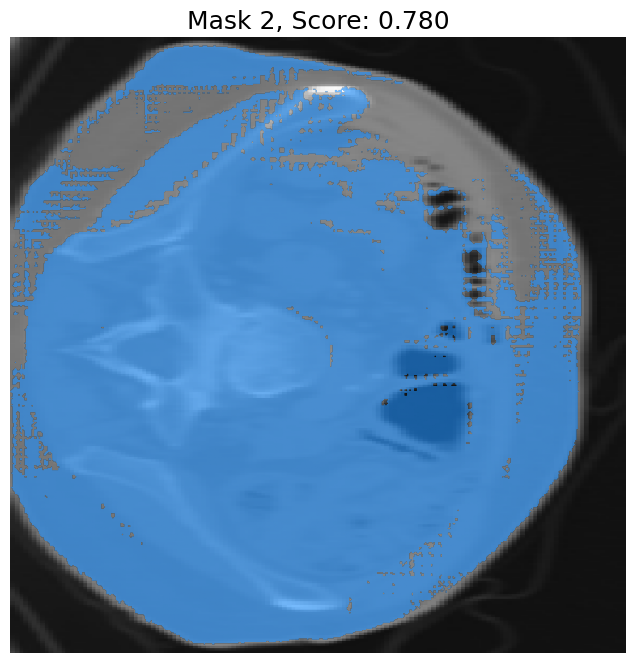

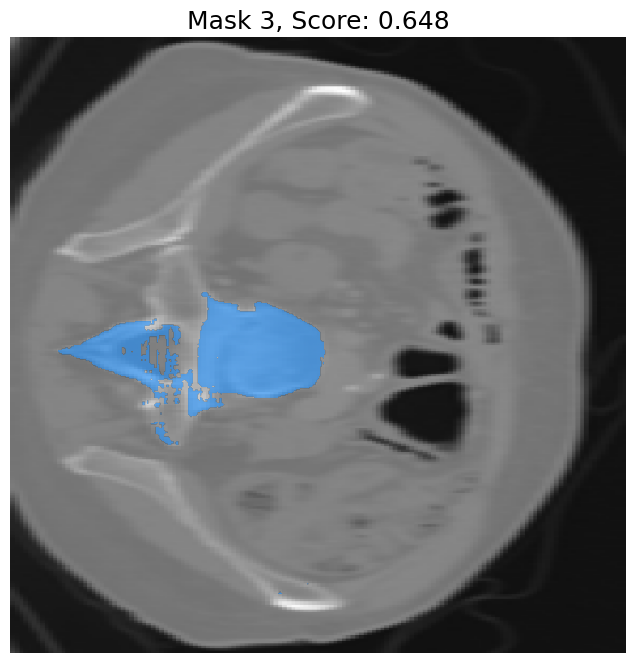

In [34]:
import cv2

image = cv2.imread('/Users/eustachelebihan/Development/radium-challenge/data/x-train/200.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(points[0].squeeze().numpy(), points[0].squeeze().numpy(), plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

# **6.** Inference

In [11]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/Users/eustachelebihan/Downloads/sam_vit_b_01ec64.pth"
model_type = "vit_b"
model = sam_model_registry[model_type](checkpoint=sam_checkpoint)

model.to(device="mps")

mask_generator = SamAutomaticMaskGenerator(model)

In [13]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="mps")

print(s)
mask_generator = SamAutomaticMaskGenerator(sam)

# **7.** training pipeline

In [44]:
# imports

import os
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import wandb
import yaml
from easydict import EasyDict
from tqdm import tqdm
import monai
import torch.nn as nn
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry

from model import RadSam
from dataset import RadSamDataset

join = os.path.join


In [45]:
# CONFIG =============================
# Load YAML config file
with open('config.yaml', 'r') as file:
    config_dict = yaml.safe_load(file)

config = EasyDict(config_dict)
run_id = datetime.now().strftime("%Y%m%d-%H%M")
device = config.training.device
model_save_path = join(config.model.work_dir, config.model.task_name + "-" + run_id)
os.makedirs(model_save_path, exist_ok=True)
# ====================================

In [ ]:
# MODEL ==============================
sam_model = sam_model_registry[config.training.model_type](checkpoint=config.training.checkpoint)
medsam_model = RadSam(
    image_encoder=sam_model.image_encoder,
    mask_decoder=sam_model.mask_decoder,
    prompt_encoder=sam_model.prompt_encoder,
    freeze_img_encoder=False
).to(device)

print("Number of total parameters: ", sum(p.numel() for p in medsam_model.parameters())) 
print("Number of trainable parameters: ", sum(p.numel() for p in medsam_model.parameters() if p.requires_grad))  # 93729252

img_mask_encdec_params = list(medsam_model.image_encoder.parameters()) + list(
    medsam_model.mask_decoder.parameters()
)
optimizer = torch.optim.AdamW(
    img_mask_encdec_params, lr=config.training.lr, weight_decay=config.training.weight_decay
)
print(
    "Number of image encoder and mask decoder parameters: ",
    sum(p.numel() for p in img_mask_encdec_params if p.requires_grad),
)  # 93729252

# optimizer
img_mask_encdec_params = list(medsam_model.image_encoder.parameters()) + list(
    medsam_model.mask_decoder.parameters()
)
optimizer = torch.optim.AdamW(
    img_mask_encdec_params, lr=config.training.lr, weight_decay=config.training.weight_decay
)

# loss
seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction="mean")
ce_loss = nn.BCEWithLogitsLoss(reduction="mean")
# ====================================